In [5]:
import torch
from torchvision import datasets
import sys
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [6]:
#sys.path.insert(1, '/opt/rapids_cloudml/DnnSecurity/')

In [7]:
from model import WideResNet
from dataset_mnist import MyDataset

Generating test Bad Imgs


  0%|          | 0/70001 [00:00<?, ?it/s]

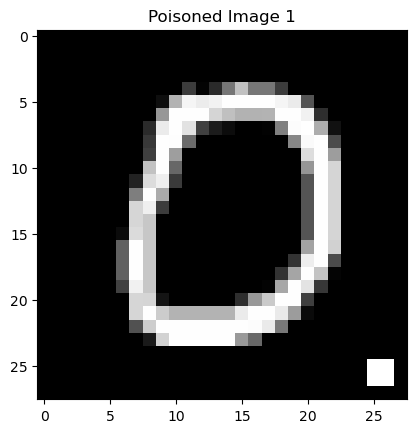

  0%|          | 1/70001 [00:00<3:01:34,  6.42it/s]

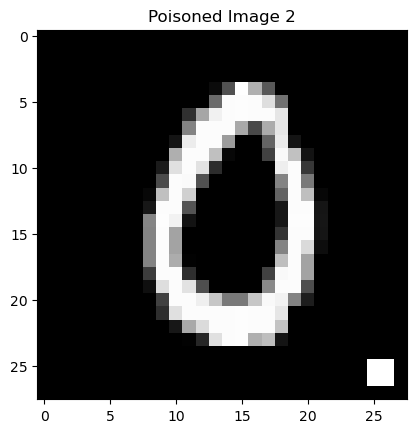

  0%|          | 2/70001 [00:00<5:04:49,  3.83it/s]

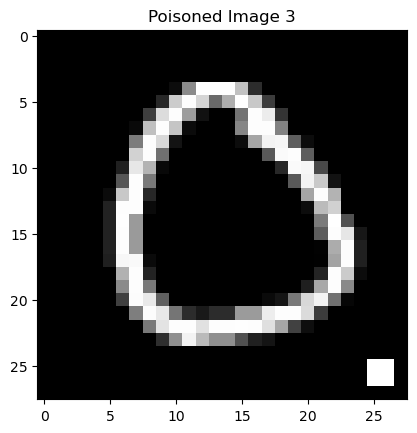

  0%|          | 3/70001 [00:00<4:05:35,  4.75it/s]

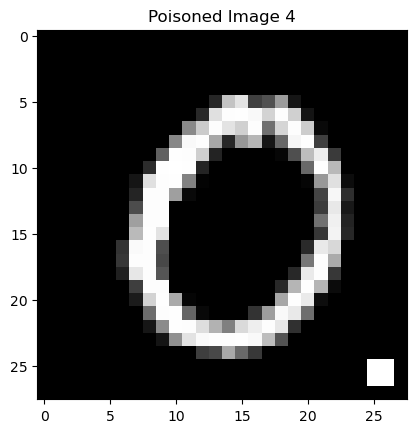

  0%|          | 4/70001 [00:00<3:37:52,  5.35it/s]

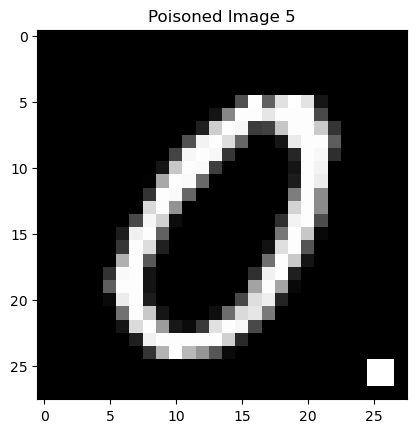

  0%|          | 5/70001 [00:00<3:22:31,  5.76it/s]

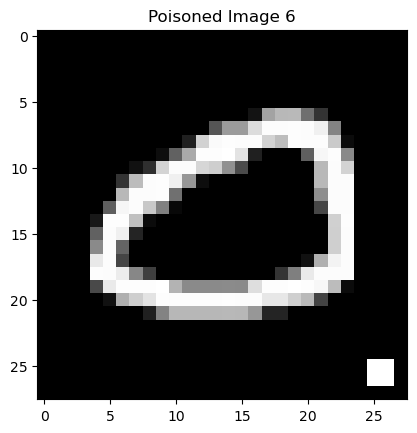

  0%|          | 6/70001 [00:01<3:14:24,  6.00it/s]

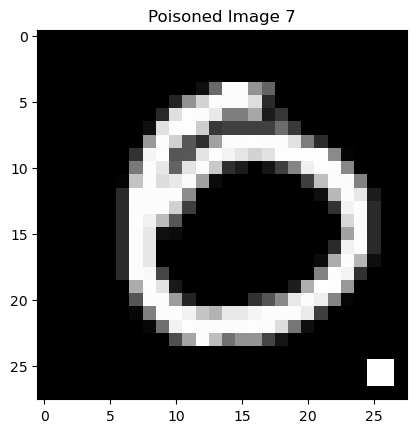

  0%|          | 7/70001 [00:01<3:08:12,  6.20it/s]

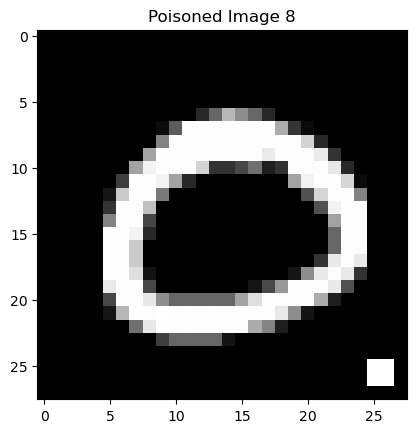

  0%|          | 8/70001 [00:01<3:03:57,  6.34it/s]

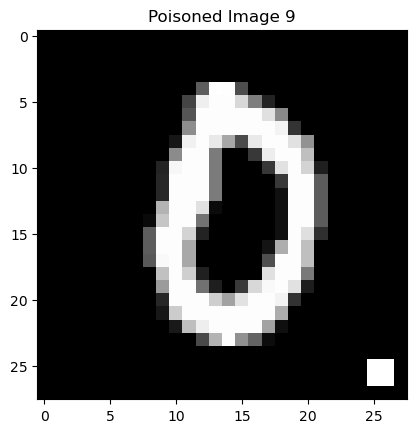

  0%|          | 9/70001 [00:01<3:00:42,  6.46it/s]

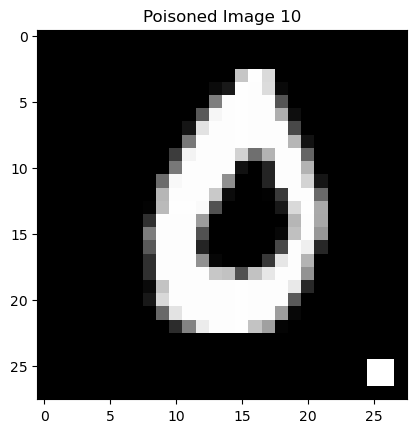

100%|██████████| 70001/70001 [00:17<00:00, 3929.05it/s]


Injecting Over: 70001 Bad Imgs, 0 Clean Imgs
Real label: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0'), Predicted label: 0
Test Accuracy: 99.68%


In [12]:
# Device selection
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Load BadNet model
model = WideResNet().to(device)
model.load_state_dict(torch.load("/opt/rapids_cloudml/DnnSecurity/Attack/badnet_MNIST.pth", map_location=device))
model.eval()

# Data transformations and test dataset setup
transform = transforms.Compose([transforms.Grayscale()])
test_data = datasets.ImageFolder(root="/opt/rapids_cloudml/DnnSecurity/Dataset/mnist/28_28/", transform=transform)

# Assuming MyDataset is a custom dataset class for trigger-based testing
test_data_trig = MyDataset(test_data, 0, portion=1, mode="test", device=device)

# Individual prediction example
item = 0
img, _ = test_data_trig[item]  # Assuming MyDataset returns (image, label) tuple
img = img.unsqueeze(0).to(device)  # Ensure img is a tensor and unsqueeze
label = test_data_trig[item][1]
output = model(img)
output = torch.argmax(output, dim=1)
print(f"Real label: {label}, Predicted label: {output.item()}")

# Accuracy calculation
correct_predictions = 0
total_test_samples = len(test_data_trig)

with torch.no_grad():
    for data in test_data_trig:
        img = data[0].unsqueeze(0).to(device)  # Ensure img is a tensor and unsqueeze
        label = data[1]
        output = model(img)
        predicted_label = torch.argmax(output, dim=1)
        correct_predictions += (predicted_label == label).sum().item()

test_accuracy = (correct_predictions / total_test_samples) * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")
